In [41]:
!pip install torchsummary

In [9]:
# Set path variables
import os
import sys
from pathlib import Path

cwd = os.getcwd()
project_dir = os.path.abspath(os.path.join(cwd, os.pardir))
sys.path.append(project_dir)
data_path = os.path.join(project_dir, 'data/')
print(project_dir)
print(data_path)

/home/seuh/Tagging-Music-Sequences
/home/seuh/Tagging-Music-Sequences/data/


In [42]:
# for data loading process

from src.audio_dataset import *
from torch.utils.data import DataLoader
import pandas as pd

import math
import numpy as np

import torch
from torch import nn
import torch.optim as optim
from torch.autograd import Variable
from torchsummary import summary
import os
from tqdm import tqdm

In [11]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [12]:
# Make sure CUDA is available
if torch.cuda.is_available():
    device_name = torch.cuda.get_device_name(torch.cuda.current_device())
    print(f"Current CUDA Device Name: {device_name}")
else:
    print("CUDA is not available. Please check your system's configuration.")

Current CUDA Device Name: Quadro RTX 8000


# CNN+Attention

## Data loading

In [21]:
# Load label annotation csv
train_annotations = 'mtat_train_label.csv'
val_annotations = 'mtat_val_label.csv'
test_annotations = 'mtat_test_label.csv'

# data path
cwd = Path.cwd()
DATA_DIR = cwd.parent / 'data'

### FOR RAW AUDIO DATA

Set transformation parameter to None

In [33]:
# Define global parameters across all classes
SAMPLE_RATE = 16000
DURATION_IN_SEC = 29.1

train_data = AudioDS(annotations_file=train_annotations, 
                     data_dir=DATA_DIR, 
                     target_sample_rate=SAMPLE_RATE, 
                     target_length=DURATION_IN_SEC, 
                     transformation=None)

val_data = AudioDS(annotations_file=val_annotations,
                     data_dir=DATA_DIR,
                     target_sample_rate=SAMPLE_RATE,
                     target_length=DURATION_IN_SEC,
                     transformation=None)

test_data = AudioDS(annotations_file=val_annotations,
                     data_dir=DATA_DIR,
                     target_sample_rate=SAMPLE_RATE,
                     target_length=DURATION_IN_SEC,
                     transformation=None)

In [34]:
# Load data from created datasets
BATCH_SIZE = 32

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

In [40]:
print(len(train_dataloader))
print(len(val_dataloader))

406
136


In [35]:
# Display batch information
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([32, 1, 465600])
Labels batch shape: torch.Size([32, 50])


In [36]:
# Retrieve a sample
idx = 0
waveform = train_features[idx]
label = train_labels[idx]
decoded_labels = train_data.decode_labels(label)
file_path = train_data.get_filepath(idx)

print(f"Audio file path: {file_path}")
print(f"Label: {label}")
print(f"Decoded labels: {decoded_labels}")

Audio file path: /home/seuh/Tagging-Music-Sequences/data/mtat/0/paul_berget-the_siena_manuscript_on_steel_string_guitar-06-recercar_6_steel_string_guitar-30-59.mp3
Label: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=torch.float64)
Decoded labels: ['rock', 'heavy']


In [37]:
# shape of waveform
# first element: number of channels in our case 1
# second element: number of samples in 30 seconds audio at a sampling rate of 16000 samples/s 
# -> 480000 = 30s * 16000 samples/s
waveform.shape

torch.Size([1, 465600])

## Build Model

### Front-end CNN+waveform

In [64]:
class WaveformNet(nn.Module):
    def __init__(self, num_classes=50):
        super(WaveformNet, self).__init__()
        
        # Strided convolution to reduce dimensionality
        self.strided_conv = nn.Conv1d(1, 128, kernel_size=3, stride=3)
        self.bn0 = nn.BatchNorm1d(128)

        # Convolutional blocks
        self.conv_blocks = nn.ModuleList()
        in_channels = 128
        out_channels = 128
        for i in range(8):
            
            if i == 3:  # 4th layer
                out_channels = 256
            if i == 7:  # Last layer
                out_channels = 512
                
            self.conv_blocks.append(nn.Conv1d(in_channels, out_channels, kernel_size=3))
            self.conv_blocks.append(nn.BatchNorm1d(out_channels))
            self.conv_blocks.append(nn.ReLU())
            self.conv_blocks.append(nn.MaxPool1d(kernel_size=3, stride=3))
            in_channels = out_channels  

        # Global max pooling
        self.global_max_pool = nn.AdaptiveMaxPool1d(1)

        # Fully connected layers
        # Adjust the input size of the first FC layer based on the output of the last convolutional block
        self.fc1 = nn.Linear(512, 256)  # Adjust 128 based on the output channels of the last conv block
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        # Initial strided convolution
        x = F.relu(self.bn0(self.strided_conv(x)))

        # Convolutional blocks
        for block in self.conv_blocks:
            x = block(x)
        
        # Global max pooling
        x = self.global_max_pool(x)
        x = x.view(x.size(0), -1)  # Flatten

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

In [65]:
model = WaveformNet(num_classes=50).to(device)
input_size = (train_features.size()[1:])  
summary(model, input_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1          [-1, 128, 155200]             512
       BatchNorm1d-2          [-1, 128, 155200]             256
            Conv1d-3          [-1, 128, 155198]          49,280
       BatchNorm1d-4          [-1, 128, 155198]             256
              ReLU-5          [-1, 128, 155198]               0
         MaxPool1d-6           [-1, 128, 51732]               0
            Conv1d-7           [-1, 128, 51730]          49,280
       BatchNorm1d-8           [-1, 128, 51730]             256
              ReLU-9           [-1, 128, 51730]               0
        MaxPool1d-10           [-1, 128, 17243]               0
           Conv1d-11           [-1, 128, 17241]          49,280
      BatchNorm1d-12           [-1, 128, 17241]             256
             ReLU-13           [-1, 128, 17241]               0
        MaxPool1d-14            [-1, 12

In [16]:
from tqdm import tqdm
import torch.optim as optim

class TrainWaveformNet:
    def __init__(self, num_classes, learning_rate, epochs, model_save_path, use_cuda):
        self.epochs = epochs
        self.model_save_path = model_save_path
        self.use_cuda = use_cuda and torch.cuda.is_available()
        self..device = torch.device("cuda" if self.use_cuda else "cpu")
        print(f"Using {self.device} device")
        
        
        # Initialize the model
        self.model = WaveformNet(num_classes=num_classes)
        self.model.to(self.device)
        
        # Use DataParallel for multiple GPUs
        if self.use_cuda and torch.cuda.device_count() > 1:
            print(f'Using {torch.cuda.device_count()} GPUs')
            self.model = nn.DataParallel(self.model) 

        # Loss function and optimizer
        self.criterion = nn.BCEWithLogitsLoss()  # Using BCEWithLogitsLoss for stability
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        
        # Initialize empty lists for tracking losses
        self.train_losses = []
        self.val_losses = []

    def save_checkpoint(self, epoch):
        # Save a checkpoint of the model
        checkpoint_path = f'{self.model_save_path}_checkpoint_epoch_{epoch}.pth'
        torch.save({
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
        }, checkpoint_path)
        print(f'Checkpoint saved: {checkpoint_path}')

    def train(self, train_dataloader, val_dataloader):
        
        pbar = tqdm(total=self.epochs, desc='Training', leave=True)

        for epoch in range(self.epochs):
            self.model.train()
            running_loss = 0.0
            
            

            for batch_idx, (batch_features, batch_labels) in enumerate(train_dataloader):
                # Convert batch_labels to float
                batch_labels = batch_labels.float()

                batch_features, batch_labels = batch_features.to(self.device), batch_labels.to(self.device)

                # Forward pass
                self.optimizer.zero_grad()
                outputs = self.model(batch_features)
                loss = self.criterion(outputs, batch_labels)
                running_loss += loss.item()

                # Backward and optimize
                loss.backward()
                self.optimizer.step()
                
            average_train_loss = running_train_loss / len(train_dataloader)
            self.train_losses.append(average_train_loss)
            
            
            
            # Validation loop
            self.model.eval()
            running_val_loss = 0.0
            with torch.no_grad():
                for batch_features, batch_labels in val_dataloader:
                    batch_labels = batch_labels.float()
                    batch_features, batch_labels = batch_features.to(self.device), batch_labels.to(self.device)

                    outputs = self.model(batch_features)
                    loss = self.criterion(outputs, batch_labels)
                    running_val_loss += loss.item()

            average_val_loss = running_val_loss / len(val_dataloader)
            self.val_losses.append(average_val_loss)
            
            

            # Update progress bar after each epoch
            pbar.set_postfix(train_loss=average_train_loss, val_loss=average_val_loss)
            pbar.update(1)

            # Save checkpoint after each epoch
            self.save_checkpoint(epoch)
        
        
        # Save the final model
        final_model_path = f'{self.model_save_path}_final.pth'
        torch.save(self.model.state_dict(), final_model_path)
        print(f'Final model saved to {final_model_path}')

        # Close the progress bar
        pbar.close()

In [17]:
# Parameters for the model and training
num_classes = 50
learning_rate = 0.001
epochs = 10
model_save_path = '../models/waveform_model'  # Adjust the path as needed

trainer = TrainWaveformNet(num_classes, learning_rate, epochs, model_save_path, use_cuda=torch.cuda.is_available())
trainer.train(train_dataloader)  # train_features and train_labels should be tensors



Training:  10%|█         | 1/10 [04:03<36:31, 243.47s/it, loss=320]

Checkpoint saved: ../models/waveform_model_checkpoint_epoch_0.pth



Training:  20%|██        | 2/10 [08:08<32:33, 244.18s/it, loss=292]

Checkpoint saved: ../models/waveform_model_checkpoint_epoch_1.pth



Training:  30%|███       | 3/10 [12:26<29:15, 250.73s/it, loss=278]

Checkpoint saved: ../models/waveform_model_checkpoint_epoch_2.pth



Training:  40%|████      | 4/10 [17:00<25:58, 259.77s/it, loss=267]

Checkpoint saved: ../models/waveform_model_checkpoint_epoch_3.pth



Training:  50%|█████     | 5/10 [21:13<21:27, 257.53s/it, loss=259]

Checkpoint saved: ../models/waveform_model_checkpoint_epoch_4.pth



Training:  60%|██████    | 6/10 [25:25<17:01, 255.44s/it, loss=253]

Checkpoint saved: ../models/waveform_model_checkpoint_epoch_5.pth



Training:  70%|███████   | 7/10 [29:26<12:32, 250.85s/it, loss=247]

Checkpoint saved: ../models/waveform_model_checkpoint_epoch_6.pth



Training:  80%|████████  | 8/10 [33:46<08:27, 253.82s/it, loss=243]

Checkpoint saved: ../models/waveform_model_checkpoint_epoch_7.pth



Training:  90%|█████████ | 9/10 [37:46<04:09, 249.47s/it, loss=239]

Checkpoint saved: ../models/waveform_model_checkpoint_epoch_8.pth



Training: 100%|██████████| 10/10 [41:46<00:00, 250.67s/it, loss=235]

Checkpoint saved: ../models/waveform_model_checkpoint_epoch_9.pth
Final model saved to ../models/waveform_model_final.pth


### Evaluation

In [23]:
from sklearn.metrics import roc_auc_score, average_precision_score

def evaluate_model(model, test_dataloader, device):
    model.eval()  # Set the model to evaluation mode
    all_outputs = []
    all_labels = []
    
    with torch.no_grad():  # No need to track gradients for evaluation
        for batch_features, batch_labels in test_dataloader:
            # Move test data to the appropriate device
            batch_features = batch_features.to(device)
            batch_labels = batch_labels.to(device)

            # Forward pass and get the output probabilities by applying sigmoid
            outputs = torch.sigmoid(model(batch_features))
            
            # Store outputs and labels
            all_outputs.append(outputs.cpu().numpy())
            all_labels.append(batch_labels.cpu().numpy())

    # Concatenate all the outputs and labels
    all_outputs = np.concatenate(all_outputs, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    # Calculate ROC AUC and PR AUC
    roc_auc = roc_auc_score(all_labels, all_outputs, average='macro')
    pr_auc = average_precision_score(all_labels, all_outputs, average='macro')

    return roc_auc, pr_auc, all_outputs, all_labels

# Evaluate the model
roc_auc, pr_auc, all_outputs, all_labels = evaluate_model(trainer.model, test_dataloader, trainer.device)
print(f'ROC AUC: {roc_auc:.4f}')
print(f'PR AUC: {pr_auc:.4f}')


ROC AUC: 0.8761
PR AUC: 0.3753


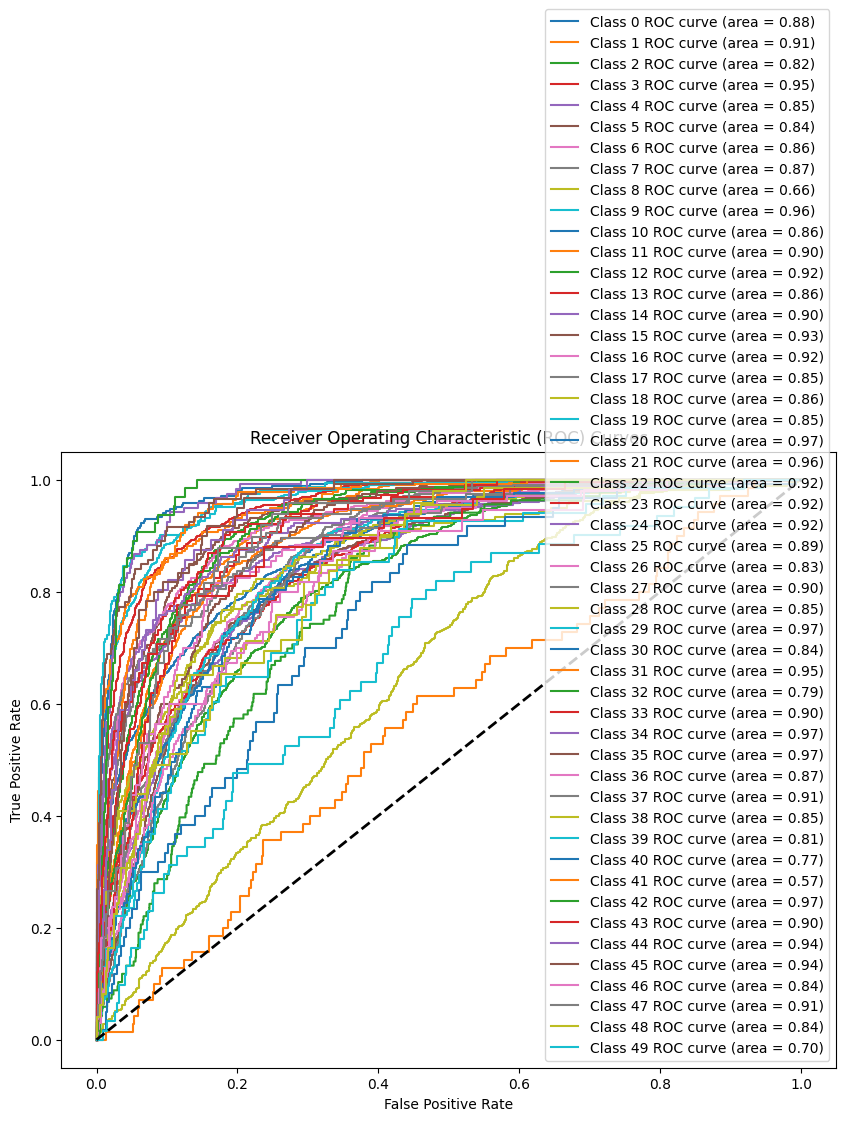

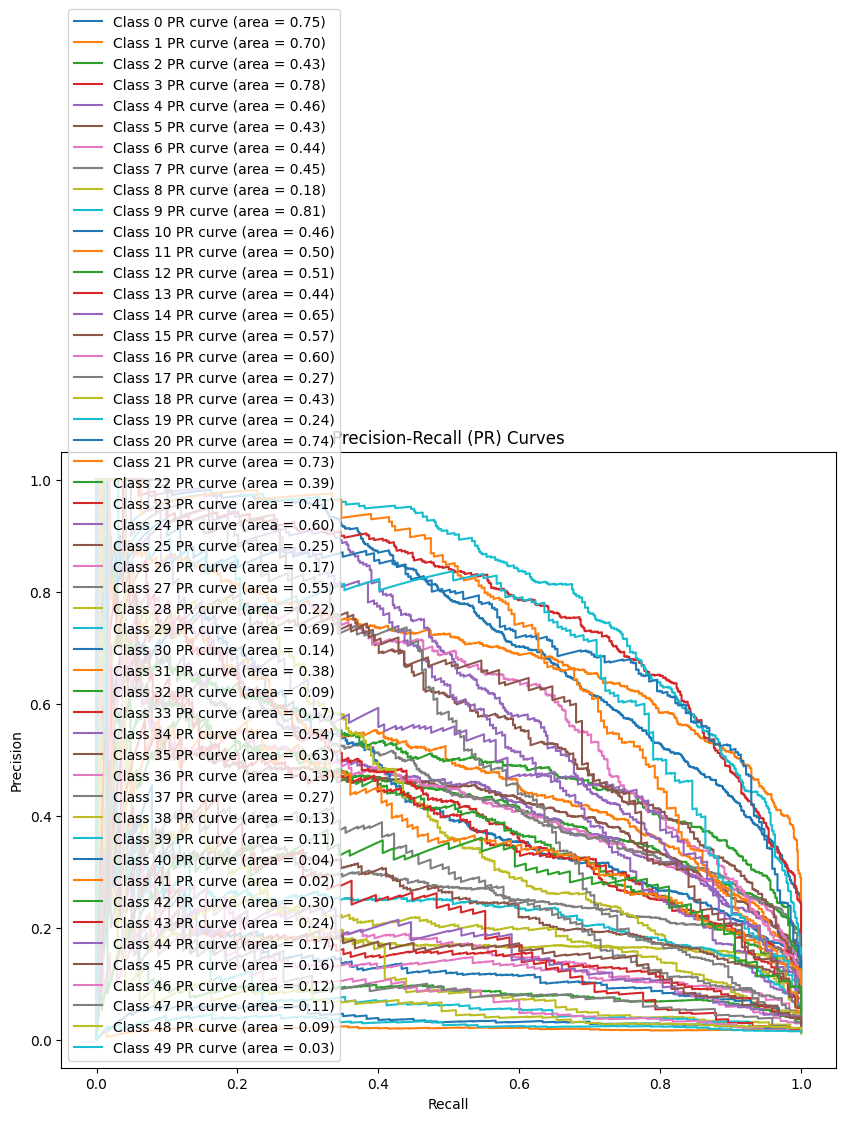

In [24]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import numpy as np

# Generate random predictions and labels for demonstration purposes
# Replace these with your actual model outputs and true labels
true_labels = all_labels
model_outputs = all_outputs

# Calculate and plot ROC Curve for each class
plt.figure(figsize=(10, 8))
for i in range(true_labels.shape[1]):
    fpr, tpr, _ = roc_curve(true_labels[:, i], model_outputs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} ROC curve (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()

# Calculate and plot Precision-Recall Curve for each class
plt.figure(figsize=(10, 8))
for i in range(true_labels.shape[1]):
    precision, recall, _ = precision_recall_curve(true_labels[:, i], model_outputs[:, i])
    pr_auc = average_precision_score(true_labels[:, i], model_outputs[:, i])
    plt.plot(recall, precision, label=f'Class {i} PR curve (area = {pr_auc:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall (PR) Curves')
plt.legend(loc="lower left")
plt.show()
